<a href="https://colab.research.google.com/github/mahmoudarekat/MetabolicSyndrome/blob/main/MetabolicSyndrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
pip install keras_tuner

###Import Necessary Libraries

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
set_config(transform_output='pandas')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf




In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

####Classification Metrics

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(list(y_true.values), y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



####Evaluate Classification

In [173]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


###Fetching Data

In [174]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/Metabolic  Syndrome.csv').set_index('seqn')
df

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,No MetSyn
71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,No MetSyn
71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,No MetSyn


###Data Cleaning

In [175]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 62161 to 71915
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(5), object(4)
memory usage: 281.4+ KB


In [177]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [178]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [179]:
null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
null_rows['MetabolicSyndrome'].value_counts()

No MetSyn    282
MetSyn       110
Name: MetabolicSyndrome, dtype: int64

In [180]:
df=df.dropna()

In [181]:
for i in df:
  print(df[i].value_counts())

80    104
63     48
50     44
60     43
21     42
     ... 
73     18
76     18
77     17
79     15
72     15
Name: Age, Length: 61, dtype: int64
Female    1022
Male       987
Name: Sex, dtype: int64
Married      1098
Single        460
Divorced      219
Widowed       144
Separated      88
Name: Marital, dtype: int64
9000.0    316
2500.0    223
3500.0    204
2000.0    177
1000.0    174
8200.0    171
1600.0    157
6200.0    124
4500.0    118
800.0     109
5400.0     94
300.0      69
1700.0     50
1500.0     23
Name: Income, dtype: int64
White          806
Black          462
Asian          295
MexAmerican    198
Hispanic       198
Other           50
Name: Race, dtype: int64
97.0     19
100.0    16
103.0    12
91.6     11
89.0     11
         ..
142.0     1
129.2     1
132.6     1
125.2     1
69.5      1
Name: WaistCirc, Length: 616, dtype: int64
24.7    21
23.3    20
25.8    18
22.0    18
24.9    18
        ..
19.7     1
68.7     1
44.8     1
51.8     1
45.3     1
Name: BMI, Length: 308, 

In [182]:
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,No MetSyn


In [183]:
y=df['MetabolicSyndrome']
X=df.drop(columns='MetabolicSyndrome')

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

####Preprocessing Numeric

In [185]:
num_cols = X_train.select_dtypes("number").drop(columns='Albuminuria').columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
num_pipe

Numeric Columns: Index(['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')


Pipeline(steps=[('standardscaler', StandardScaler())])

In [186]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Save list of column names
ord_cols = ['Albuminuria']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
Alb_order = ['0','1','2']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [Alb_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(ord_encoder, scaler_ord)
ord_pipe

Ordinal Columns: ['Albuminuria']


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['0', '1', '2']])),
                ('standardscaler', StandardScaler())])

In [187]:
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Sex', 'Marital', 'Race'], dtype='object')


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [188]:
num_tuple = ('numeric', num_pipe, num_cols)
ord_tuple=('ordinal',ord_pipe,ord_cols)
ohe_tuple=('categorical', ohe_pipe, ohe_cols)

In [189]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

In [190]:
X_train

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
69994,21,Female,Single,6200.0,Other,64.2,18.2,0,26.45,3.6,94,61,71
68237,63,Male,Married,4500.0,White,102.5,29.6,0,3.33,6.7,101,46,80
65335,55,Male,Married,5400.0,Asian,107.0,29.3,0,6.24,7.1,98,46,65
70489,40,Male,Married,3500.0,Hispanic,105.8,30.3,0,3.24,5.5,103,55,75
66851,46,Female,Widowed,9000.0,White,107.2,28.7,0,7.09,5.3,103,64,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67741,28,Female,Married,4500.0,White,99.0,23.3,0,5.55,4.5,83,65,194
68502,27,Male,Single,1600.0,Black,99.2,28.9,0,4.55,6.3,84,43,81
66399,61,Male,Married,9000.0,Black,107.7,32.3,0,7.35,7.0,143,52,158


In [191]:
logreg=LogisticRegression(C=10)
scaler=StandardScaler()
logreg_pipe=make_pipeline(col_transformer,logreg)
logreg_pipe.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               '1',
                                                                                               '2']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Albuminuria']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(C=10))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.82      0.74      0.78       531
   No MetSyn       0.87      0.91      0.89       975

    accuracy                           0.85      1506
   macro avg       0.84      0.82      0.83      1506
weighted avg       0.85      0.85      0.85      1506



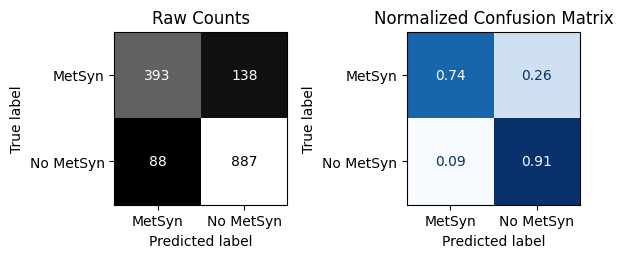


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.74      0.72      0.73       181
   No MetSyn       0.84      0.86      0.85       322

    accuracy                           0.81       503
   macro avg       0.79      0.79      0.79       503
weighted avg       0.81      0.81      0.81       503



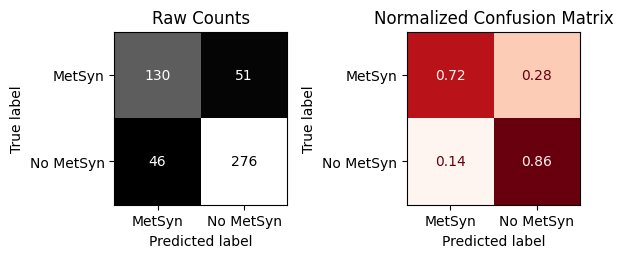

In [192]:
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)


In [193]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)
X_train.head()


,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
69994,21,Female,Single,6200.0,Other,64.2,18.2,0,26.45,3.6,94,61,71
68237,63,Male,Married,4500.0,White,102.5,29.6,0,3.33,6.7,101,46,80
65335,55,Male,Married,5400.0,Asian,107.0,29.3,0,6.24,7.1,98,46,65
70489,40,Male,Married,3500.0,Hispanic,105.8,30.3,0,3.24,5.5,103,55,75
66851,46,Female,Widowed,9000.0,White,107.2,28.7,0,7.09,5.3,103,64,80


###Clustering

In [194]:
X_trans=col_transformer.transform(X)


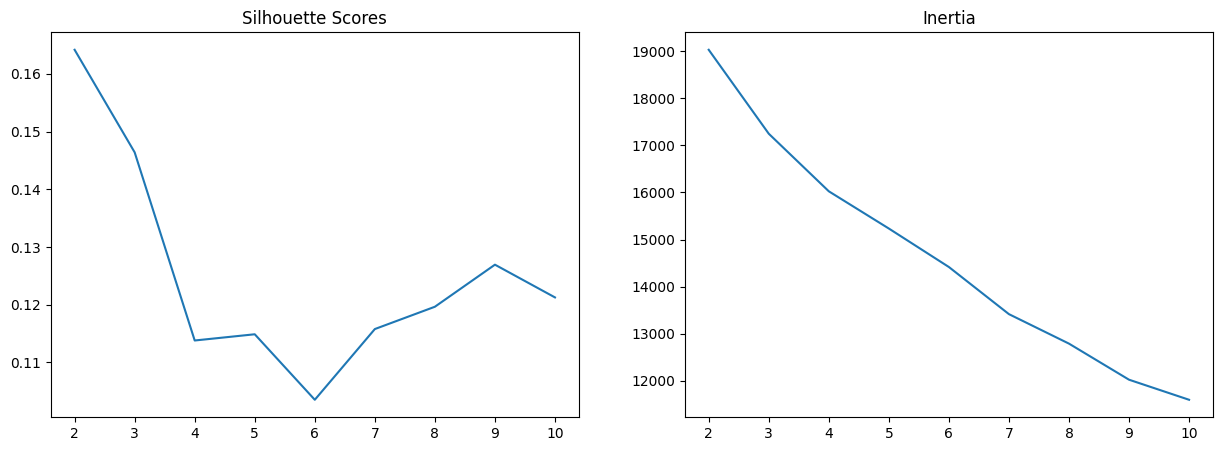

In [195]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_trans)
  sils.append(silhouette_score(X_trans, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [196]:
# Refit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, n_init= 'auto', random_state=42)
kmeans.fit(X_trans)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

<ipython-input-196-08dab6a8d9f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,cluster
seqn,,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn,1
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn,1
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn,1
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn,0
62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,No MetSyn,0


In [197]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

<ipython-input-197-5eb2330caace>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_groups = df.groupby('cluster', as_index=False).mean()


,cluster,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
0,0,54.759364,3677.979569,111.299886,33.369807,0.256527,76.865607,6.249830,121.583428,45.611805,167.064699
1,1,44.971631,4513.652482,88.545922,25.112411,0.062057,15.220239,4.899202,97.406028,59.751773,95.517730


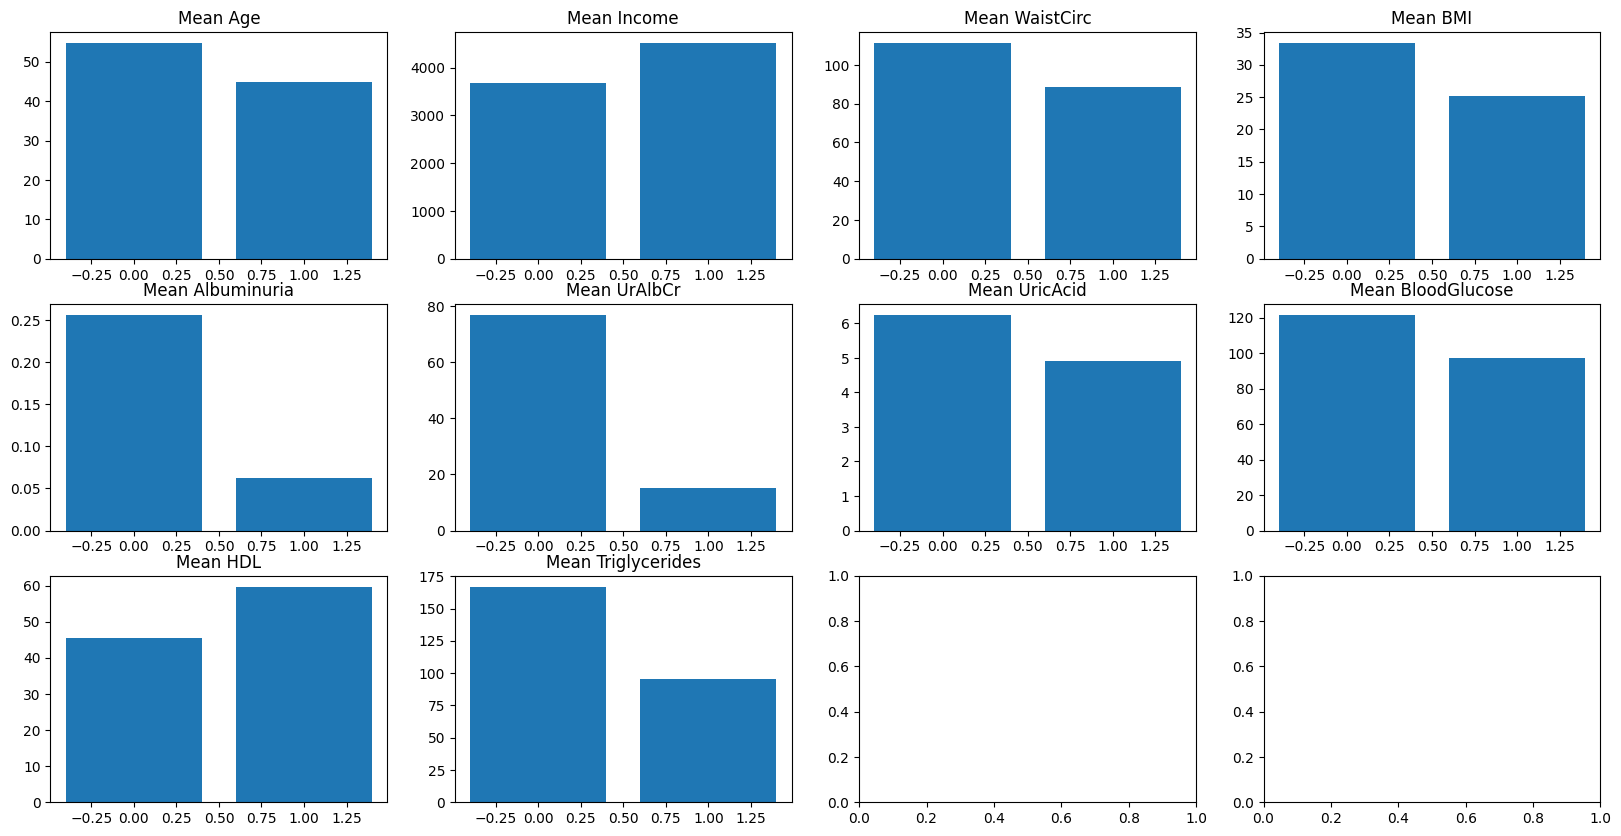

In [198]:
# Visualize means
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

###Neural Network

In [199]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [200]:
y=y.replace('MetSyn',1)
y=y.replace('No MetSyn',0)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [202]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)

In [203]:
X_train_tf=col_transformer.fit_transform(X_train)
X_test_tf=col_transformer.transform(X_test)
X_val_tf=col_transformer.transform(X_val)

In [204]:
input_shape = X_train_tf.shape[1]
input_shape

20

In [205]:
# Build binary classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(20, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model



In [206]:
# Call our build function to build model
model = build_model()

# Get model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [207]:
len(X_train_tf)-len(y_train)

0

In [208]:
history = model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=2)



Epoch 1/50
38/38 - 2s - loss: 0.6114 - accuracy: 0.6827 - precision_1: 0.5536 - recall_1: 0.5118 - val_loss: 0.5485 - val_accuracy: 0.7881 - val_precision_1: 0.7792 - val_recall_1: 0.5607 - 2s/epoch - 44ms/step
Epoch 2/50
38/38 - 0s - loss: 0.5077 - accuracy: 0.7641 - precision_1: 0.7059 - recall_1: 0.5660 - val_loss: 0.4583 - val_accuracy: 0.8113 - val_precision_1: 0.7976 - val_recall_1: 0.6262 - 203ms/epoch - 5ms/step
Epoch 3/50
38/38 - 0s - loss: 0.4458 - accuracy: 0.7957 - precision_1: 0.7392 - recall_1: 0.6486 - val_loss: 0.4097 - val_accuracy: 0.8179 - val_precision_1: 0.7766 - val_recall_1: 0.6822 - 118ms/epoch - 3ms/step
Epoch 4/50
38/38 - 0s - loss: 0.4071 - accuracy: 0.8048 - precision_1: 0.7520 - recall_1: 0.6651 - val_loss: 0.3874 - val_accuracy: 0.8311 - val_precision_1: 0.7800 - val_recall_1: 0.7290 - 167ms/epoch - 4ms/step
Epoch 5/50
38/38 - 0s - loss: 0.3912 - accuracy: 0.8206 - precision_1: 0.7587 - recall_1: 0.7193 - val_loss: 0.3762 - val_accuracy: 0.8411 - val_preci

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'precision_1'}>,
        <Axes: title={'center': 'recall_1'}>], dtype=object))

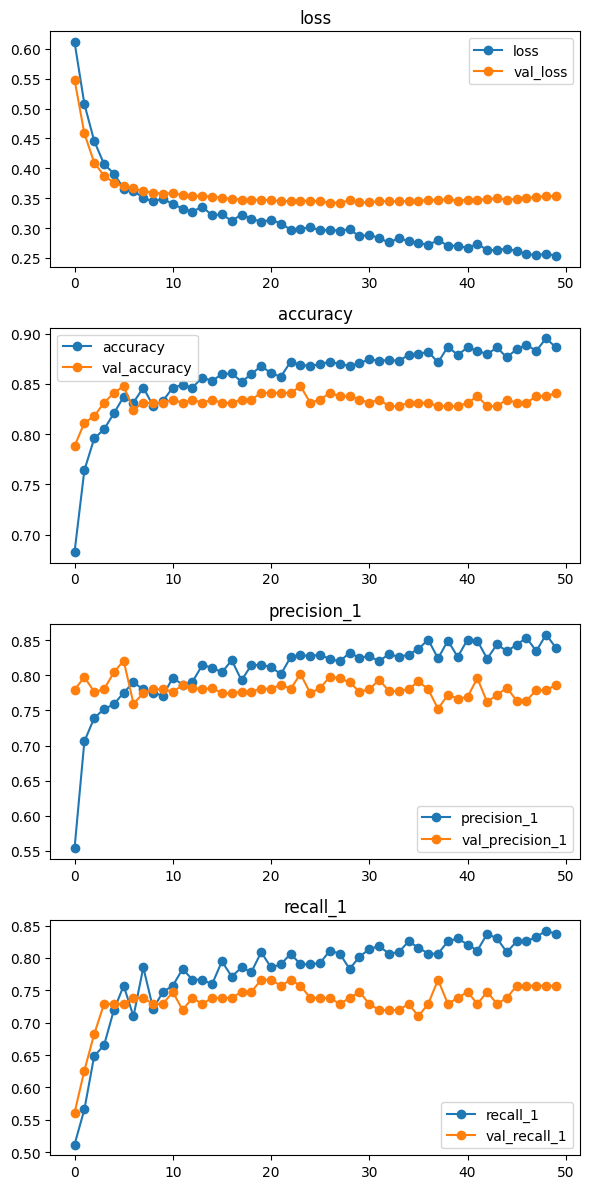

In [209]:
plot_history(history)

In [210]:
# make predictions
y_pred_test = model.predict(X_test_tf)
y_pred_test[:5]



8/8 [==============================] - 0s 2ms/step


array([[6.5707439e-01],
       [1.3972636e-01],
       [2.1007404e-01],
       [4.1951755e-01],
       [2.3819102e-04]], dtype=float32)

In [211]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]



array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       161
           1       0.76      0.81      0.79        91

    accuracy                           0.84       252
   macro avg       0.83      0.84      0.83       252
weighted avg       0.84      0.84      0.84       252



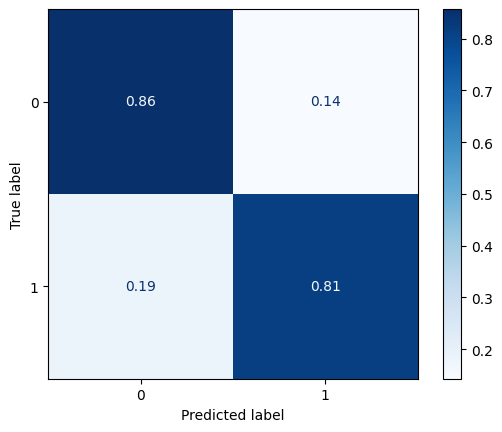

In [212]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');



#####Keras Tuner

In [213]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt


In [214]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



In [215]:
# Build and Compile Model within a function to try different optimizers, units, and dropout values
def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(20, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu'))
    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    # Try different optimizers
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [216]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Metabolic_syndrome')



In [220]:
# Run the tuner
epochs = 100
tuner.search(X_train_tf, y_train,  epochs=epochs,
             validation_data = (pd.DataFrame(X_val_tf), pd.DataFrame(y_val)))



Trial 84 Complete [00h 00m 08s]
val_loss: 0.4191116392612457

Best val_loss So Far: 0.37238410115242004
Total elapsed time: 00h 05m 45s


In [221]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values



{'units': 45,
 'dropout_value': 0.2,
 'optimizer': 'adam',
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [222]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 45)                945       
                                                                 
 dropout (Dropout)           (None, 45)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [223]:
# Evaluate neural network with tuned optimizer, units, and dropout
result = best_model.evaluate(X_test_tf, y_test, return_dict=True)
result



8/8 [==============================] - 1s 4ms/step - loss: 0.3124 - accuracy: 0.8651 - recall: 0.8352 - precision: 0.8000


{'loss': 0.31235477328300476,
 'accuracy': 0.8650793433189392,
 'recall': 0.8351648449897766,
 'precision': 0.800000011920929}

In [224]:
history = best_model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=2)


Epoch 1/50
38/38 - 2s - loss: 0.2524 - accuracy: 0.8854 - recall: 0.8160 - precision: 0.8522 - val_loss: 0.2419 - val_accuracy: 0.8808 - val_recall: 0.8411 - val_precision: 0.8257 - 2s/epoch - 40ms/step
Epoch 2/50
38/38 - 0s - loss: 0.2516 - accuracy: 0.8920 - recall: 0.8561 - precision: 0.8403 - val_loss: 0.2484 - val_accuracy: 0.8775 - val_recall: 0.8318 - val_precision: 0.8241 - 163ms/epoch - 4ms/step
Epoch 3/50
38/38 - 0s - loss: 0.2413 - accuracy: 0.8978 - recall: 0.8656 - precision: 0.8476 - val_loss: 0.2542 - val_accuracy: 0.8808 - val_recall: 0.8224 - val_precision: 0.8381 - 181ms/epoch - 5ms/step
Epoch 4/50
38/38 - 0s - loss: 0.2418 - accuracy: 0.8978 - recall: 0.8302 - precision: 0.8734 - val_loss: 0.2558 - val_accuracy: 0.8742 - val_recall: 0.8224 - val_precision: 0.8224 - 174ms/epoch - 5ms/step
Epoch 5/50
38/38 - 0s - loss: 0.2394 - accuracy: 0.9020 - recall: 0.8608 - precision: 0.8608 - val_loss: 0.2595 - val_accuracy: 0.8742 - val_recall: 0.8224 - val_precision: 0.8224 - 